In [1]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

import threading
import sys
import cv2
import sys
import os
import csv
import itertools
import numpy as np
from PIL import Image
import imageio
import itertools as it
import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)

Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0


In [2]:
# Add the standard include path for FoosMetrics
sys.path.insert(0, './../../Code')

import importlib
import process
importlib.reload(process)

<module 'process' from './../../Code\\process.py'>

In [3]:
# Load the data and frames, and add the normalizer
training = process.Processor("data_loader_training.json")
validation = process.Processor("data_loader_validation.json")
output_names = ["g1","d1","o1","f1","f2","o2","d2","g2","-2"]

Creating transform: random_video_loader
Adding folder '.\..\..\Data\Processed\BallTracking\'
'.\..\..\Data\Processed\BallTracking\balltracking_0.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_1.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_10.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_11.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_12.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_13.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_14.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_15.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_16.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_17.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_18.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\bal

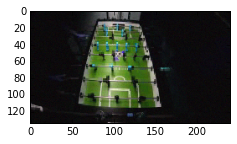

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


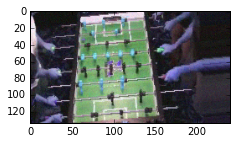

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


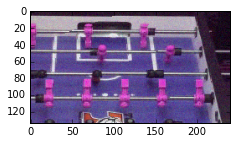

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])


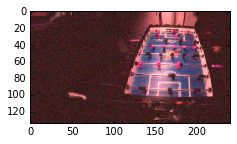

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


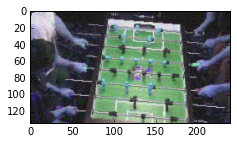

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])


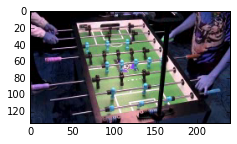

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


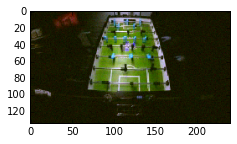

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


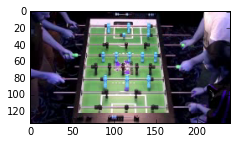

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


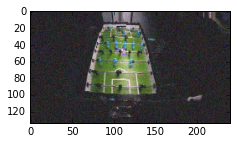

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])


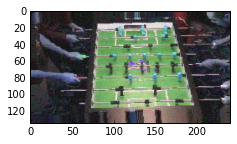

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


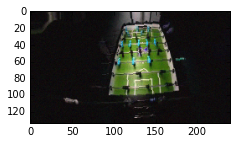

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


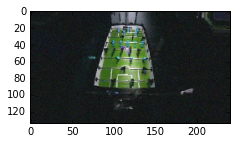

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


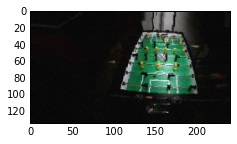

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


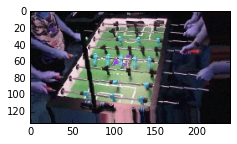

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


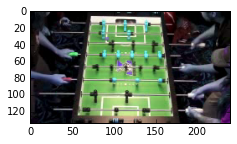

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


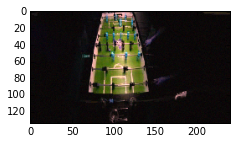

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


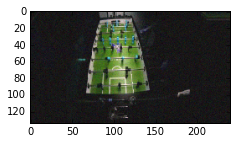

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


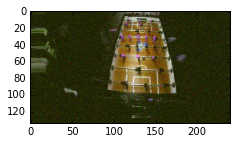

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


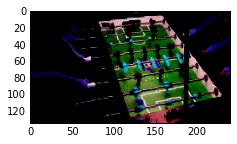

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


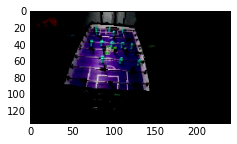

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


In [4]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# View the first few frames
for k in range(20):
    data = training.get_next_frame()
    frame = data["frame"]
    fig, ax = plt.subplots(figsize=(18, 2))
    plt.imshow(frame)
    plt.show()
    pp.pprint( np.transpose( np.array(data["values"] ) ))

In [5]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g


# Define our training and validation iterators
@threadsafe_generator
def TrainGen(training):
    while True:
        data = training.get_next_frame()
        if data is not None:
            frame = data["frame"]
            output = np.array(data["values"])

            while frame is not None:
                yield (frame, output)
                data = training.get_next_frame()
                if data is not None:
                    frame = data["frame"]
                    output = np.array(data["values"])
                else:
                    frame = None
                
             
# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, training):
    gen = TrainGen(training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

                
             
# Generators for training the position
@threadsafe_generator
def ValidationBatchGen(batch_size, validation):
    gen = TrainGen(validation)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
    
    
        
    


In [6]:
# Utilities for plotting the result and training
def plot_validate(generator, model, count, name, output_names):   
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    
    f, axes = plt.subplots(outputs_true.shape[1], figsize=(12, 12), sharex=True, sharey=True)
    
    for i in range(outputs_true.shape[1]):
        true, predicted = zip(*sorted(zip(outputs_true[0:count,i], outputs_predicted[0:count,i])))
        axes[i].plot(range(count),true, label="True position" )
        axes[i].plot(range(count),predicted, label="Predicted position" )
        axes[i].grid(False)
        axes[i].set_ylabel(output_names[i])
        if i == 0:
            axes[i].legend()
            axes[i].set_title(name)
            
    
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
    
    plt.show()

    
    



In [7]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model



image_height       = 134
image_width        = 240
image_channels     = 3

# Model options
batch_size = 10
lstm_output_size = 300
cnn_kernel_count = 40

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

# Build a functional model design
inputs = Input(shape=(image_height, image_width, image_channels,),
              name="Input")
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling2D( pool_size=(1, 2),
                  name = "max_pooling2d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1


#x = Flatten()(x)
#x = Reshape((number_of_frames,6*6*cnn_kernel_count))(x)
x = Flatten()(x)


x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(9, activation='softmax',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


model.summary()

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\Goalie3Frames\\weights_%i.hdf'
MODELS_FNAME = '.\\Goalie3Frames\\models_%i.h5'

'Input shape without batches:'
(134, 240, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 134, 240, 3)       0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 134, 240, 40)      1120      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 134, 240, 40)      14440     
_________________________________________________________________
max_pooling2d_0 (MaxPooling2 (None, 134, 120, 40)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
max_pooling3d_1 (MaxPooling2 (N

Batch size 30: 1279 training batches, 319 validation batches
Epoch 1/1
1280/1279 [==============================] - 682s - loss: 2.1758 - categorical_accuracy: 0.1482 - val_loss: 2.0980 - val_categorical_accuracy: 0.2051


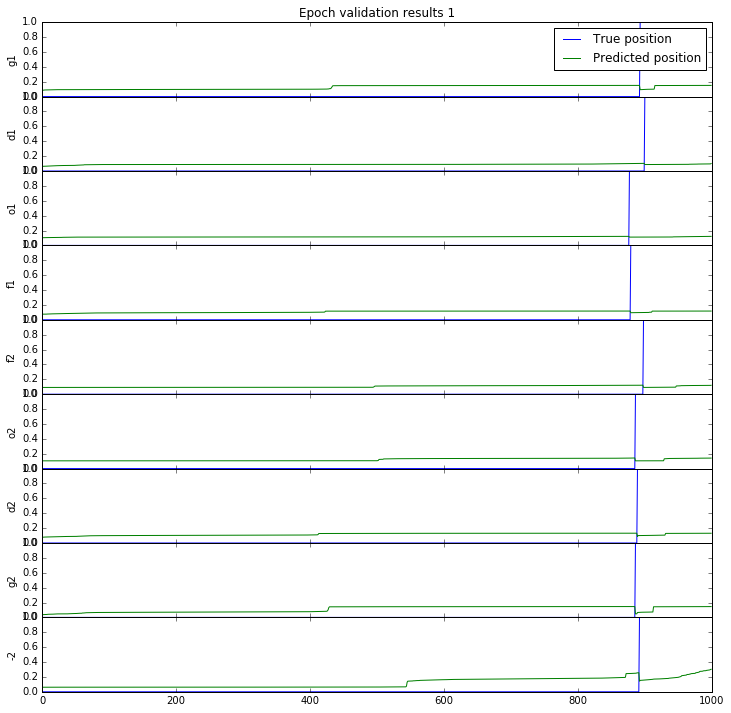

Wrote model to .\Models\weights_1.hdf
Epoch 2/2
1280/1279 [==============================] - 595s - loss: 2.1096 - categorical_accuracy: 0.1901 - val_loss: 2.0141 - val_categorical_accuracy: 0.2364
Wrote model to .\Models\weights_2.hdf
Epoch 3/3
1280/1279 [==============================] - 596s - loss: 2.0659 - categorical_accuracy: 0.2032 - val_loss: 1.9639 - val_categorical_accuracy: 0.2507
Wrote model to .\Models\weights_3.hdf
Epoch 4/4
1280/1279 [==============================] - 596s - loss: 2.0278 - categorical_accuracy: 0.2176 - val_loss: 1.9386 - val_categorical_accuracy: 0.2865
Wrote model to .\Models\weights_4.hdf
Epoch 5/5
1280/1279 [==============================] - 594s - loss: 1.9979 - categorical_accuracy: 0.2311 - val_loss: 1.9032 - val_categorical_accuracy: 0.3120
Wrote model to .\Models\weights_5.hdf
Epoch 6/6
1280/1279 [==============================] - 598s - loss: 1.9839 - categorical_accuracy: 0.2388 - val_loss: 1.8799 - val_categorical_accuracy: 0.3895
Wrote mode

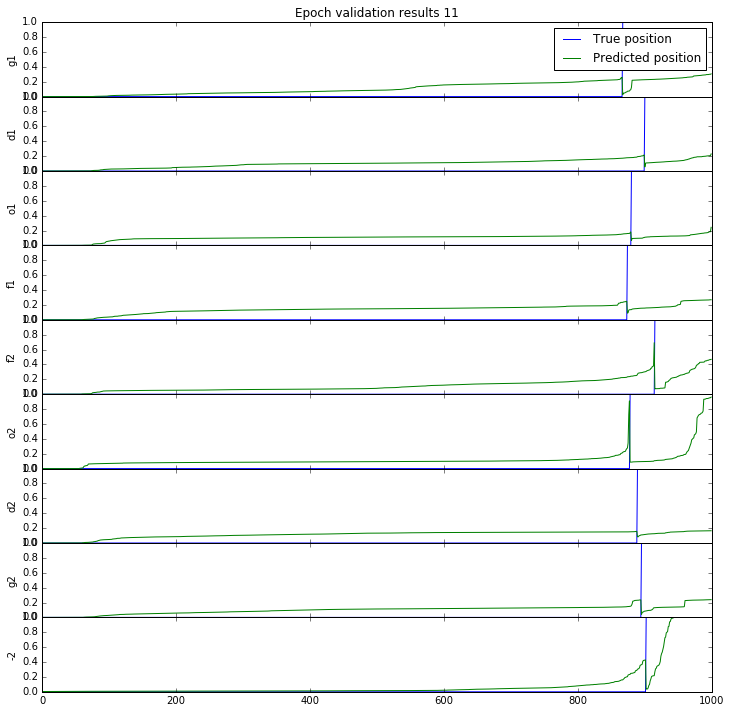

Wrote model to .\Models\weights_11.hdf
Epoch 12/12
1280/1279 [==============================] - 595s - loss: 1.8705 - categorical_accuracy: 0.2981 - val_loss: 1.5911 - val_categorical_accuracy: 0.4598
Wrote model to .\Models\weights_12.hdf
Epoch 13/13
1280/1279 [==============================] - 597s - loss: 1.8477 - categorical_accuracy: 0.3081 - val_loss: 1.5065 - val_categorical_accuracy: 0.5254
Wrote model to .\Models\weights_13.hdf
Epoch 14/14
1280/1279 [==============================] - 596s - loss: 1.8125 - categorical_accuracy: 0.3246 - val_loss: 1.4345 - val_categorical_accuracy: 0.5451
Wrote model to .\Models\weights_14.hdf
Epoch 15/15
1280/1279 [==============================] - 596s - loss: 1.7817 - categorical_accuracy: 0.3410 - val_loss: 1.3103 - val_categorical_accuracy: 0.6036
Wrote model to .\Models\weights_15.hdf
Epoch 16/16
1280/1279 [==============================] - 592s - loss: 1.7540 - categorical_accuracy: 0.3505 - val_loss: 1.2101 - val_categorical_accuracy: 0.

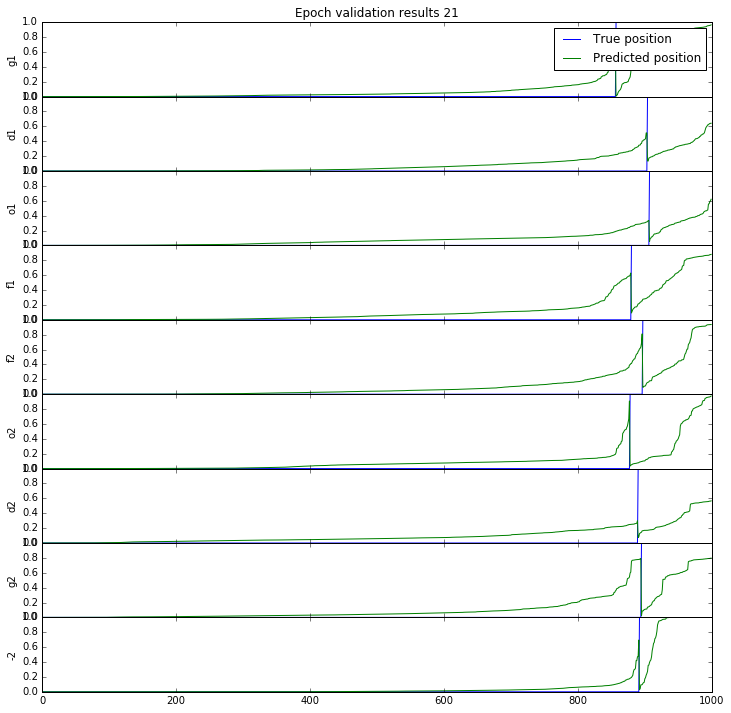

Wrote model to .\Models\weights_21.hdf
Epoch 22/22
1280/1279 [==============================] - 594s - loss: 1.5617 - categorical_accuracy: 0.4253 - val_loss: 0.8360 - val_categorical_accuracy: 0.7526
Wrote model to .\Models\weights_22.hdf
Epoch 23/23
1280/1279 [==============================] - 596s - loss: 1.5186 - categorical_accuracy: 0.4410 - val_loss: 0.7601 - val_categorical_accuracy: 0.7875
Wrote model to .\Models\weights_23.hdf
Epoch 24/24
1280/1279 [==============================] - 596s - loss: 1.5066 - categorical_accuracy: 0.4451 - val_loss: 0.7286 - val_categorical_accuracy: 0.7900
Wrote model to .\Models\weights_24.hdf
Epoch 25/25
1280/1279 [==============================] - 599s - loss: 1.4877 - categorical_accuracy: 0.4541 - val_loss: 0.7230 - val_categorical_accuracy: 0.7871
Wrote model to .\Models\weights_25.hdf
Epoch 26/26
1280/1279 [==============================] - 599s - loss: 1.4581 - categorical_accuracy: 0.4697 - val_loss: 0.7066 - val_categorical_accuracy: 0.

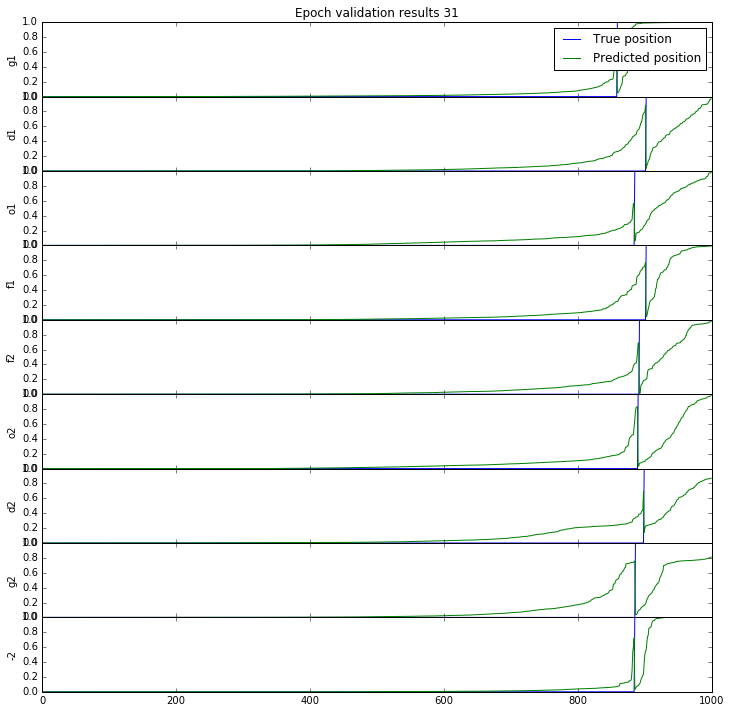

Wrote model to .\Models\weights_31.hdf
Epoch 32/32
1280/1279 [==============================] - 599s - loss: 1.3159 - categorical_accuracy: 0.5250 - val_loss: 0.5572 - val_categorical_accuracy: 0.8265
Wrote model to .\Models\weights_32.hdf
Epoch 33/33
1280/1279 [==============================] - 597s - loss: 1.3017 - categorical_accuracy: 0.5299 - val_loss: 0.5062 - val_categorical_accuracy: 0.8494
Wrote model to .\Models\weights_33.hdf
Epoch 34/34
1280/1279 [==============================] - 596s - loss: 1.3037 - categorical_accuracy: 0.5279 - val_loss: 0.5277 - val_categorical_accuracy: 0.8310
Wrote model to .\Models\weights_34.hdf
Epoch 35/35
1280/1279 [==============================] - 599s - loss: 1.2834 - categorical_accuracy: 0.5357 - val_loss: 0.5077 - val_categorical_accuracy: 0.8523
Wrote model to .\Models\weights_35.hdf
Epoch 36/36
1280/1279 [==============================] - 599s - loss: 1.2569 - categorical_accuracy: 0.5443 - val_loss: 0.4923 - val_categorical_accuracy: 0.

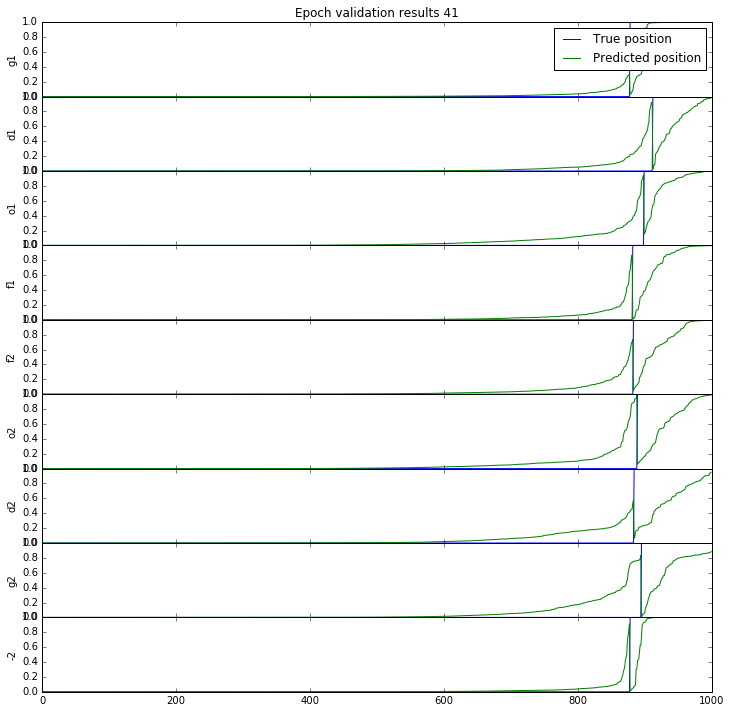

Wrote model to .\Models\weights_41.hdf
Epoch 42/42
1280/1279 [==============================] - 598s - loss: 1.1613 - categorical_accuracy: 0.5843 - val_loss: 0.4264 - val_categorical_accuracy: 0.8615
Wrote model to .\Models\weights_42.hdf
Epoch 43/43
1280/1279 [==============================] - 595s - loss: 1.1577 - categorical_accuracy: 0.5847 - val_loss: 0.4033 - val_categorical_accuracy: 0.8682
Wrote model to .\Models\weights_43.hdf
Epoch 44/44
1280/1279 [==============================] - 596s - loss: 1.1541 - categorical_accuracy: 0.5899 - val_loss: 0.4230 - val_categorical_accuracy: 0.8680
Wrote model to .\Models\weights_44.hdf
Epoch 45/45
1280/1279 [==============================] - 600s - loss: 1.1393 - categorical_accuracy: 0.5948 - val_loss: 0.4157 - val_categorical_accuracy: 0.8642
Wrote model to .\Models\weights_45.hdf
Epoch 46/46
1280/1279 [==============================] - 593s - loss: 1.1111 - categorical_accuracy: 0.6042 - val_loss: 0.3853 - val_categorical_accuracy: 0.

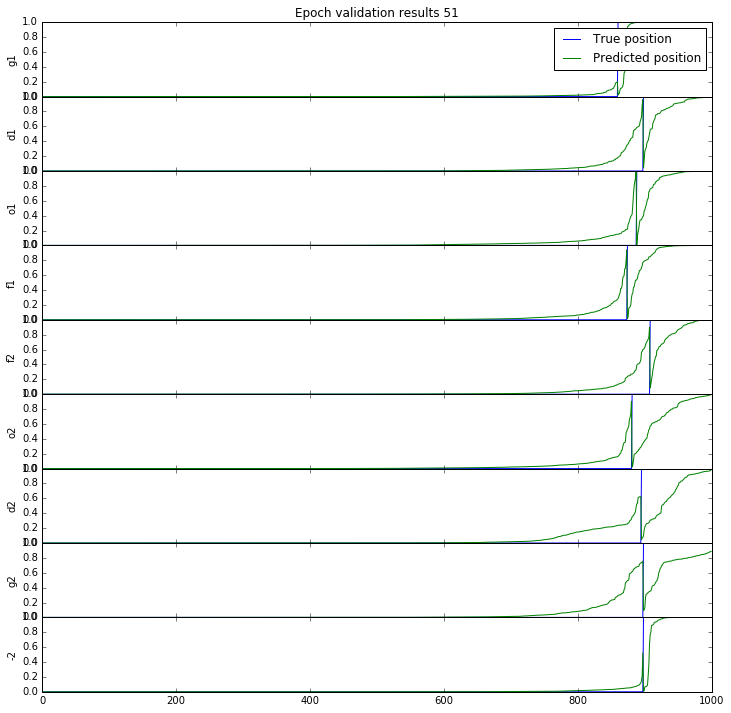

Wrote model to .\Models\weights_51.hdf
Epoch 52/52
1280/1279 [==============================] - 595s - loss: 1.0540 - categorical_accuracy: 0.6238 - val_loss: 0.3535 - val_categorical_accuracy: 0.8760
Wrote model to .\Models\weights_52.hdf
Epoch 53/53
1280/1279 [==============================] - 596s - loss: 1.0521 - categorical_accuracy: 0.6293 - val_loss: 0.3459 - val_categorical_accuracy: 0.8785
Wrote model to .\Models\weights_53.hdf
Epoch 54/54
1280/1279 [==============================] - 594s - loss: 1.0396 - categorical_accuracy: 0.6305 - val_loss: 0.3318 - val_categorical_accuracy: 0.8813
Wrote model to .\Models\weights_54.hdf
Epoch 55/55
1280/1279 [==============================] - 598s - loss: 1.0245 - categorical_accuracy: 0.6364 - val_loss: 0.3231 - val_categorical_accuracy: 0.8893
Wrote model to .\Models\weights_55.hdf
Epoch 56/56
1280/1279 [==============================] - 596s - loss: 1.0124 - categorical_accuracy: 0.6402 - val_loss: 0.3487 - val_categorical_accuracy: 0.

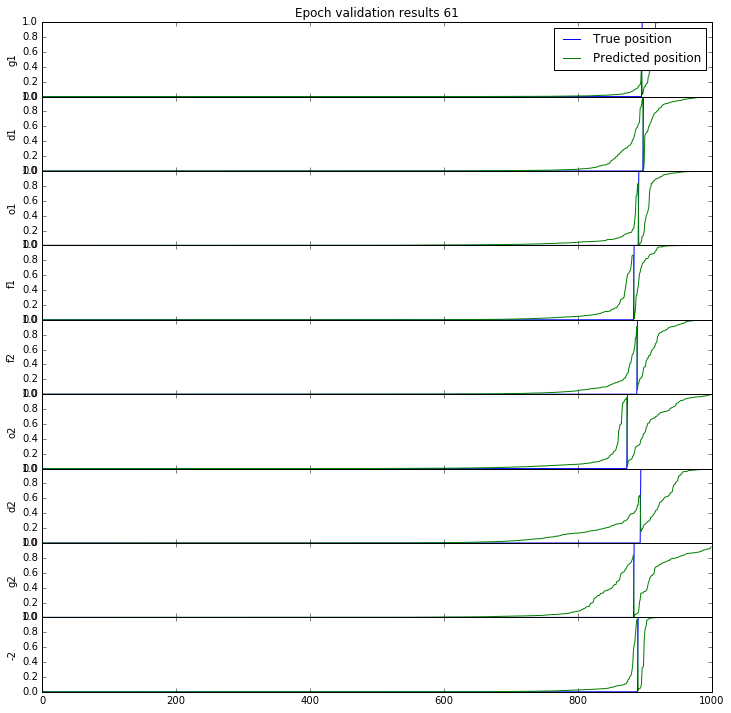

Wrote model to .\Models\weights_61.hdf
Epoch 62/62
1280/1279 [==============================] - 598s - loss: 0.9815 - categorical_accuracy: 0.6559 - val_loss: 0.2894 - val_categorical_accuracy: 0.9107
Wrote model to .\Models\weights_62.hdf
Epoch 63/63
1280/1279 [==============================] - 596s - loss: 0.9628 - categorical_accuracy: 0.6573 - val_loss: 0.2922 - val_categorical_accuracy: 0.8979
Wrote model to .\Models\weights_63.hdf
Epoch 64/64
1280/1279 [==============================] - 597s - loss: 0.9532 - categorical_accuracy: 0.6648 - val_loss: 0.3222 - val_categorical_accuracy: 0.8971
Wrote model to .\Models\weights_64.hdf
Epoch 65/65
1280/1279 [==============================] - 596s - loss: 0.9541 - categorical_accuracy: 0.6666 - val_loss: 0.3036 - val_categorical_accuracy: 0.9068
Wrote model to .\Models\weights_65.hdf
Epoch 66/66
1280/1279 [==============================] - 598s - loss: 0.9402 - categorical_accuracy: 0.6695 - val_loss: 0.2922 - val_categorical_accuracy: 0.

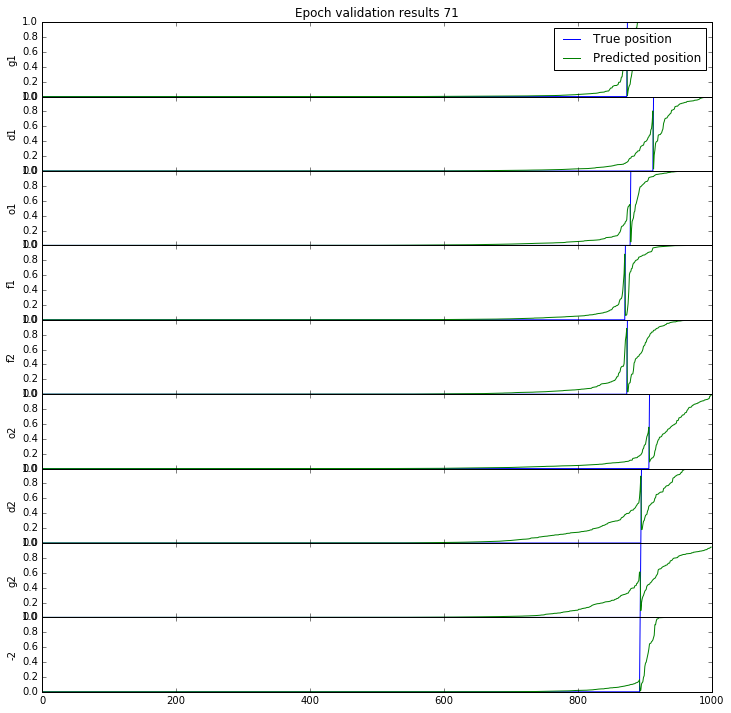

Wrote model to .\Models\weights_71.hdf
Epoch 72/72
1280/1279 [==============================] - 595s - loss: 0.9084 - categorical_accuracy: 0.6875 - val_loss: 0.2759 - val_categorical_accuracy: 0.8984
Wrote model to .\Models\weights_72.hdf
Epoch 73/73
1280/1279 [==============================] - 596s - loss: 0.9007 - categorical_accuracy: 0.6862 - val_loss: 0.2456 - val_categorical_accuracy: 0.9225
Wrote model to .\Models\weights_73.hdf
Epoch 74/74
1280/1279 [==============================] - 593s - loss: 0.8914 - categorical_accuracy: 0.6897 - val_loss: 0.2557 - val_categorical_accuracy: 0.9188
Wrote model to .\Models\weights_74.hdf
Epoch 75/75
1280/1279 [==============================] - 595s - loss: 0.8923 - categorical_accuracy: 0.6885 - val_loss: 0.2551 - val_categorical_accuracy: 0.9229
Wrote model to .\Models\weights_75.hdf
Epoch 76/76
1280/1279 [==============================] - 595s - loss: 0.8863 - categorical_accuracy: 0.6878 - val_loss: 0.2498 - val_categorical_accuracy: 0.

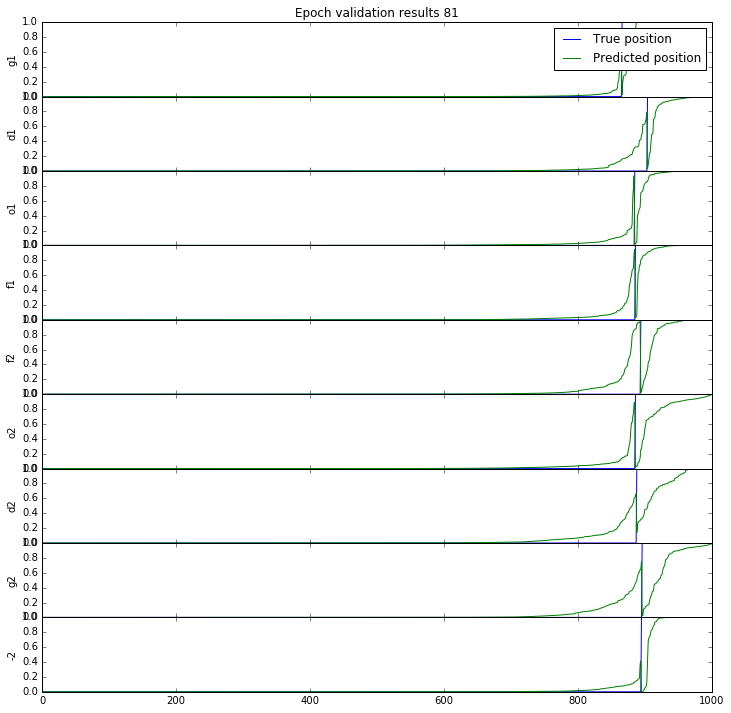

Wrote model to .\Models\weights_81.hdf
Epoch 82/82
1280/1279 [==============================] - 597s - loss: 0.8560 - categorical_accuracy: 0.7066 - val_loss: 0.2567 - val_categorical_accuracy: 0.9169
Wrote model to .\Models\weights_82.hdf
Epoch 83/83
1280/1279 [==============================] - 596s - loss: 0.8423 - categorical_accuracy: 0.7082 - val_loss: 0.2391 - val_categorical_accuracy: 0.9178
Wrote model to .\Models\weights_83.hdf
Epoch 84/84
1280/1279 [==============================] - 594s - loss: 0.8436 - categorical_accuracy: 0.7061 - val_loss: 0.2384 - val_categorical_accuracy: 0.9243
Wrote model to .\Models\weights_84.hdf
Epoch 85/85
1280/1279 [==============================] - 594s - loss: 0.8462 - categorical_accuracy: 0.7075 - val_loss: 0.2492 - val_categorical_accuracy: 0.9233
Wrote model to .\Models\weights_85.hdf
Epoch 86/86
1280/1279 [==============================] - 601s - loss: 0.8382 - categorical_accuracy: 0.7114 - val_loss: 0.2301 - val_categorical_accuracy: 0.

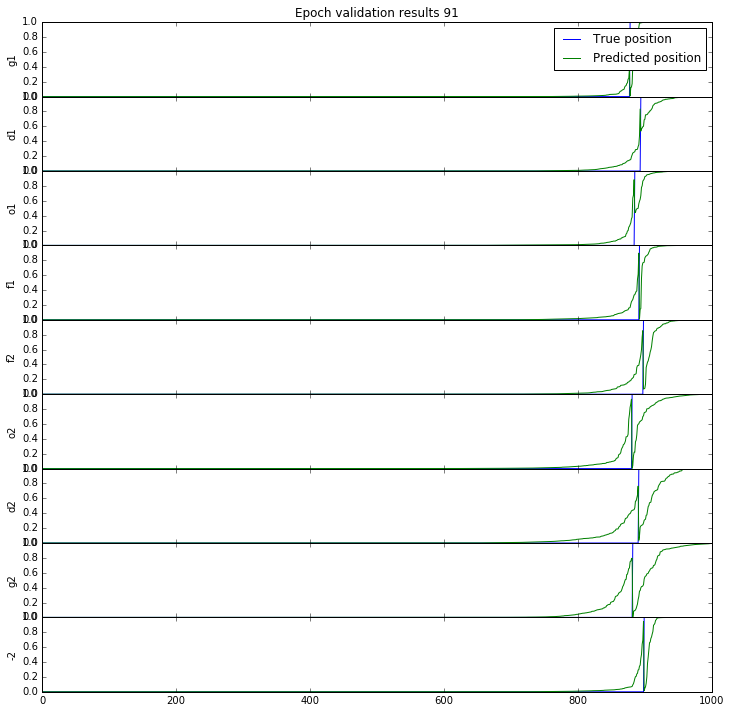

Wrote model to .\Models\weights_91.hdf
Epoch 92/92
1280/1279 [==============================] - 594s - loss: 0.8033 - categorical_accuracy: 0.7257 - val_loss: 0.2116 - val_categorical_accuracy: 0.9308
Wrote model to .\Models\weights_92.hdf
Epoch 93/93
1280/1279 [==============================] - 598s - loss: 0.8016 - categorical_accuracy: 0.7240 - val_loss: 0.1981 - val_categorical_accuracy: 0.9342
Wrote model to .\Models\weights_93.hdf
Epoch 94/94
1280/1279 [==============================] - 596s - loss: 0.7981 - categorical_accuracy: 0.7242 - val_loss: 0.2085 - val_categorical_accuracy: 0.9399
Wrote model to .\Models\weights_94.hdf
Epoch 95/95
1280/1279 [==============================] - 598s - loss: 0.8052 - categorical_accuracy: 0.7258 - val_loss: 0.2054 - val_categorical_accuracy: 0.9340
Wrote model to .\Models\weights_95.hdf
Epoch 96/96
1280/1279 [==============================] - 596s - loss: 0.7918 - categorical_accuracy: 0.7273 - val_loss: 0.2199 - val_categorical_accuracy: 0.

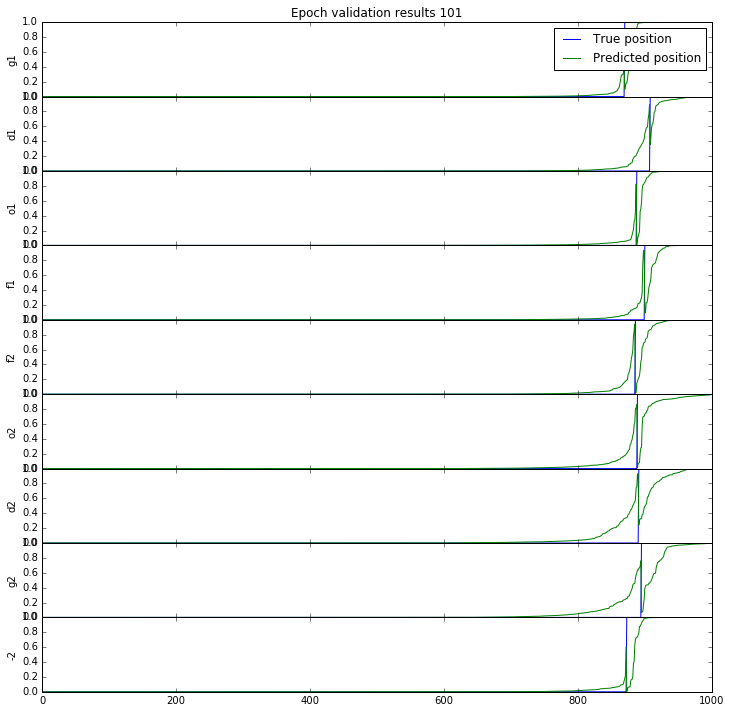

Wrote model to .\Models\weights_101.hdf
Epoch 102/102
1280/1279 [==============================] - 599s - loss: 0.7701 - categorical_accuracy: 0.7347 - val_loss: 0.1928 - val_categorical_accuracy: 0.9417
Wrote model to .\Models\weights_102.hdf
Epoch 103/103
1280/1279 [==============================] - 598s - loss: 0.7701 - categorical_accuracy: 0.7361 - val_loss: 0.1905 - val_categorical_accuracy: 0.9382
Wrote model to .\Models\weights_103.hdf
Epoch 104/104
1280/1279 [==============================] - 598s - loss: 0.7759 - categorical_accuracy: 0.7378 - val_loss: 0.1925 - val_categorical_accuracy: 0.9398
Wrote model to .\Models\weights_104.hdf
Epoch 105/105
1280/1279 [==============================] - 597s - loss: 0.7653 - categorical_accuracy: 0.7384 - val_loss: 0.1816 - val_categorical_accuracy: 0.9375
Wrote model to .\Models\weights_105.hdf
Epoch 106/106
1280/1279 [==============================] - 600s - loss: 0.7556 - categorical_accuracy: 0.7431 - val_loss: 0.1881 - val_categoric

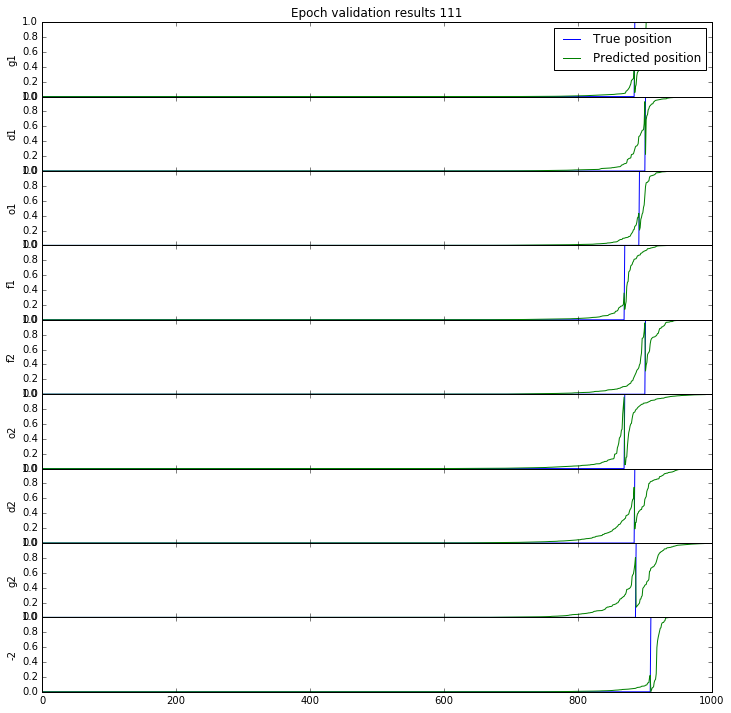

Wrote model to .\Models\weights_111.hdf
Epoch 112/112
1280/1279 [==============================] - 597s - loss: 0.7380 - categorical_accuracy: 0.7494 - val_loss: 0.1717 - val_categorical_accuracy: 0.9488
Wrote model to .\Models\weights_112.hdf
Epoch 113/113
1280/1279 [==============================] - 593s - loss: 0.7317 - categorical_accuracy: 0.7493 - val_loss: 0.1689 - val_categorical_accuracy: 0.9433
Wrote model to .\Models\weights_113.hdf
Epoch 114/114
1280/1279 [==============================] - 598s - loss: 0.7386 - categorical_accuracy: 0.7501 - val_loss: 0.1765 - val_categorical_accuracy: 0.9407
Wrote model to .\Models\weights_114.hdf
Epoch 115/115
1280/1279 [==============================] - 597s - loss: 0.7300 - categorical_accuracy: 0.7533 - val_loss: 0.1657 - val_categorical_accuracy: 0.9416
Wrote model to .\Models\weights_115.hdf
Epoch 116/116
1280/1279 [==============================] - 597s - loss: 0.7253 - categorical_accuracy: 0.7564 - val_loss: 0.1811 - val_categoric

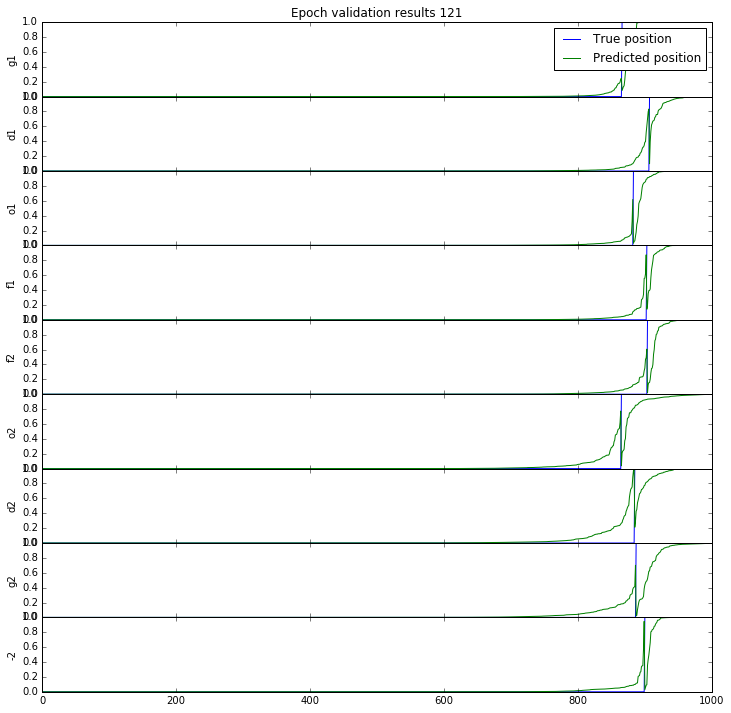

Wrote model to .\Models\weights_121.hdf
Epoch 122/122
1280/1279 [==============================] - 599s - loss: 0.7166 - categorical_accuracy: 0.7576 - val_loss: 0.1669 - val_categorical_accuracy: 0.9481
Wrote model to .\Models\weights_122.hdf
Epoch 123/123
1280/1279 [==============================] - 599s - loss: 0.7043 - categorical_accuracy: 0.7620 - val_loss: 0.1746 - val_categorical_accuracy: 0.9449
Wrote model to .\Models\weights_123.hdf
Epoch 124/124
1280/1279 [==============================] - 603s - loss: 0.7145 - categorical_accuracy: 0.7592 - val_loss: 0.1553 - val_categorical_accuracy: 0.9516
Wrote model to .\Models\weights_124.hdf
Epoch 125/125
1280/1279 [==============================] - 597s - loss: 0.6940 - categorical_accuracy: 0.7651 - val_loss: 0.1554 - val_categorical_accuracy: 0.9486
Wrote model to .\Models\weights_125.hdf
Epoch 126/126
1280/1279 [==============================] - 596s - loss: 0.6988 - categorical_accuracy: 0.7646 - val_loss: 0.1444 - val_categoric

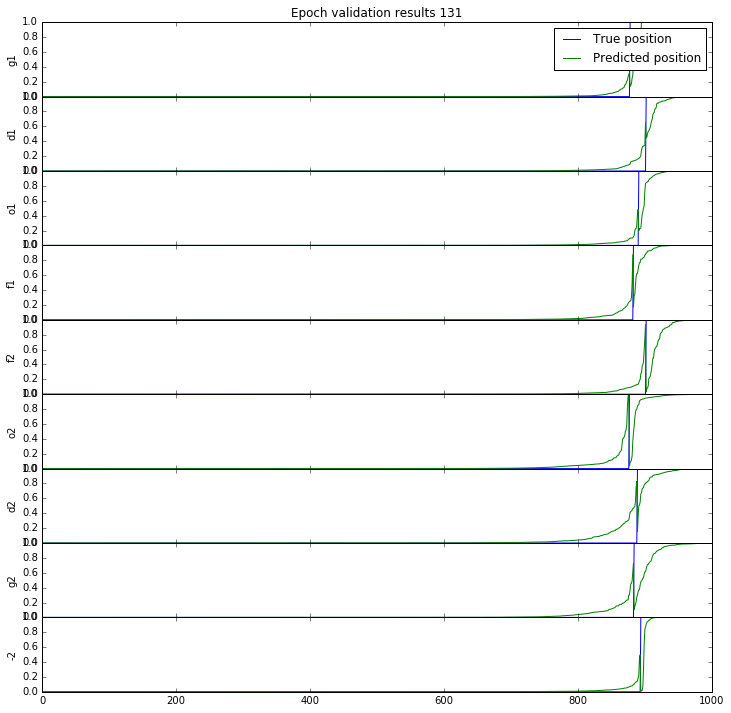

Wrote model to .\Models\weights_131.hdf
Epoch 132/132
1280/1279 [==============================] - 602s - loss: 0.6876 - categorical_accuracy: 0.7725 - val_loss: 0.1541 - val_categorical_accuracy: 0.9538
Wrote model to .\Models\weights_132.hdf
Epoch 133/133
1280/1279 [==============================] - 599s - loss: 0.6795 - categorical_accuracy: 0.7704 - val_loss: 0.1681 - val_categorical_accuracy: 0.9479
Wrote model to .\Models\weights_133.hdf
Epoch 134/134
1280/1279 [==============================] - 601s - loss: 0.6724 - categorical_accuracy: 0.7753 - val_loss: 0.1595 - val_categorical_accuracy: 0.9552
Wrote model to .\Models\weights_134.hdf
Epoch 135/135
1280/1279 [==============================] - 599s - loss: 0.6698 - categorical_accuracy: 0.7742 - val_loss: 0.1437 - val_categorical_accuracy: 0.9597
Wrote model to .\Models\weights_135.hdf
Epoch 136/136
1280/1279 [==============================] - 598s - loss: 0.6773 - categorical_accuracy: 0.7754 - val_loss: 0.1619 - val_categoric

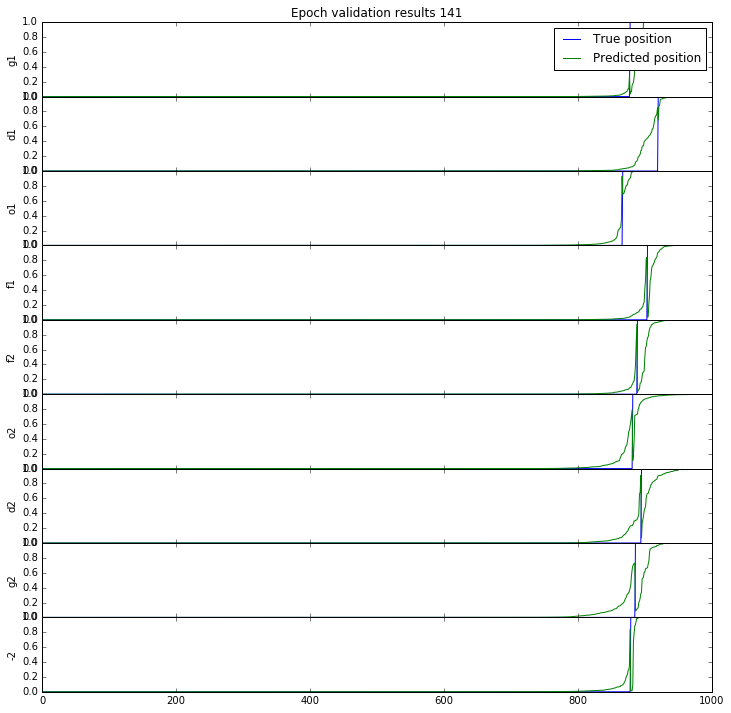

Wrote model to .\Models\weights_141.hdf
Epoch 142/142
1280/1279 [==============================] - 596s - loss: 0.6606 - categorical_accuracy: 0.7807 - val_loss: 0.1544 - val_categorical_accuracy: 0.9498
Wrote model to .\Models\weights_142.hdf
Epoch 143/143
 958/1279 [=====================>........] - ETA: 138s - loss: 0.6586 - categorical_accuracy: 0.7818

KeyboardInterrupt: 

In [8]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 0
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 30
batches_training_per_epoch = int(training.length / batch_size) / 5
batches_validation_per_epoch = int(validation.length / batch_size) / 5
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)



Batch size 30: 1279 training batches, 319 validation batches
Epoch 144/144
1280/1279 [==============================] - 603s - loss: 0.6053 - categorical_accuracy: 0.7963 - val_loss: 0.1198 - val_categorical_accuracy: 0.9625


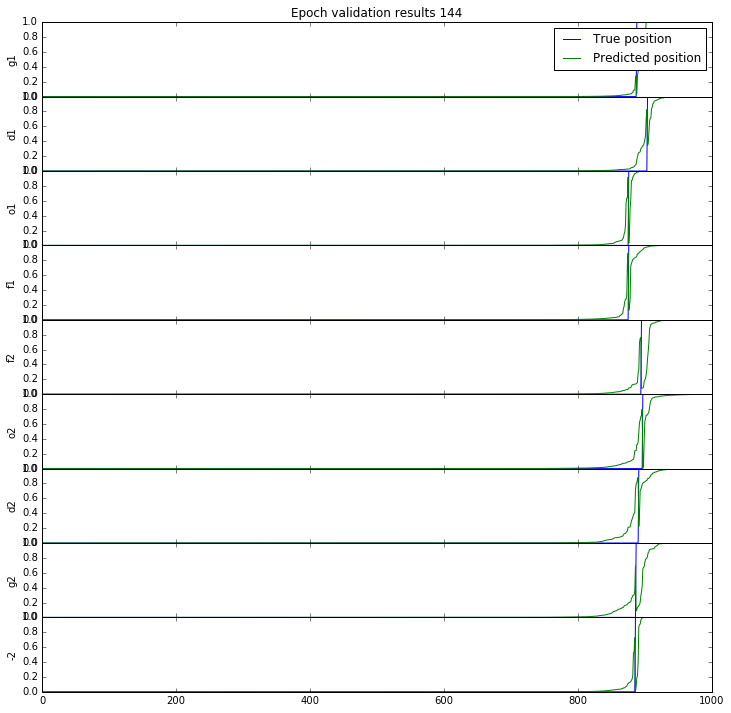

Wrote model to .\Models\weights_144.hdf
Epoch 145/145
1280/1279 [==============================] - 600s - loss: 0.6015 - categorical_accuracy: 0.8003 - val_loss: 0.1255 - val_categorical_accuracy: 0.9602
Wrote model to .\Models\weights_145.hdf
Epoch 146/146
1280/1279 [==============================] - 598s - loss: 0.6038 - categorical_accuracy: 0.7989 - val_loss: 0.1206 - val_categorical_accuracy: 0.9617
Wrote model to .\Models\weights_146.hdf
Epoch 147/147
1280/1279 [==============================] - 598s - loss: 0.6027 - categorical_accuracy: 0.7990 - val_loss: 0.1259 - val_categorical_accuracy: 0.9598
Wrote model to .\Models\weights_147.hdf
Epoch 148/148
1280/1279 [==============================] - 601s - loss: 0.5982 - categorical_accuracy: 0.8006 - val_loss: 0.1226 - val_categorical_accuracy: 0.9611
Wrote model to .\Models\weights_148.hdf
Epoch 149/149
1280/1279 [==============================] - 598s - loss: 0.5998 - categorical_accuracy: 0.8011 - val_loss: 0.1131 - val_categoric

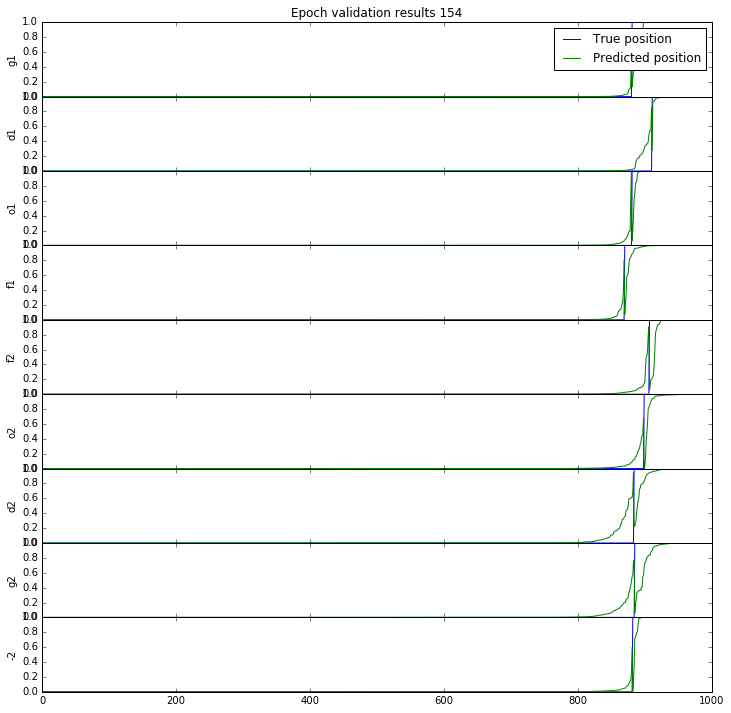

Wrote model to .\Models\weights_154.hdf
Epoch 155/155
1280/1279 [==============================] - 596s - loss: 0.5922 - categorical_accuracy: 0.8030 - val_loss: 0.1241 - val_categorical_accuracy: 0.9581
Wrote model to .\Models\weights_155.hdf
Epoch 156/156
1280/1279 [==============================] - 602s - loss: 0.6021 - categorical_accuracy: 0.7988 - val_loss: 0.1144 - val_categorical_accuracy: 0.9614
Wrote model to .\Models\weights_156.hdf
Epoch 157/157
1280/1279 [==============================] - 597s - loss: 0.5914 - categorical_accuracy: 0.8020 - val_loss: 0.1072 - val_categorical_accuracy: 0.9636
Wrote model to .\Models\weights_157.hdf
Epoch 158/158
1280/1279 [==============================] - 601s - loss: 0.5934 - categorical_accuracy: 0.8020 - val_loss: 0.1132 - val_categorical_accuracy: 0.9635
Wrote model to .\Models\weights_158.hdf
Epoch 159/159
1280/1279 [==============================] - 601s - loss: 0.5896 - categorical_accuracy: 0.8033 - val_loss: 0.1225 - val_categoric

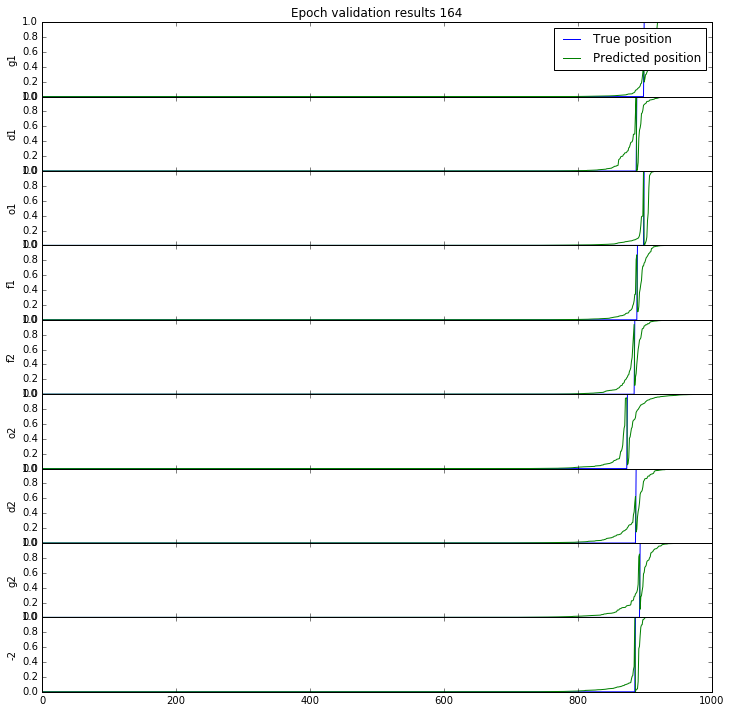

Wrote model to .\Models\weights_164.hdf
Epoch 165/165
1280/1279 [==============================] - 599s - loss: 0.5912 - categorical_accuracy: 0.8017 - val_loss: 0.1081 - val_categorical_accuracy: 0.9656
Wrote model to .\Models\weights_165.hdf
Epoch 166/166
1280/1279 [==============================] - 600s - loss: 0.5906 - categorical_accuracy: 0.8041 - val_loss: 0.1059 - val_categorical_accuracy: 0.9678
Wrote model to .\Models\weights_166.hdf
Epoch 167/167
1280/1279 [==============================] - 600s - loss: 0.5981 - categorical_accuracy: 0.8004 - val_loss: 0.1076 - val_categorical_accuracy: 0.9623
Wrote model to .\Models\weights_167.hdf
Epoch 168/168
1280/1279 [==============================] - 598s - loss: 0.5925 - categorical_accuracy: 0.8025 - val_loss: 0.1089 - val_categorical_accuracy: 0.9644
Wrote model to .\Models\weights_168.hdf
Epoch 169/169
1280/1279 [==============================] - 597s - loss: 0.5942 - categorical_accuracy: 0.8040 - val_loss: 0.1107 - val_categoric

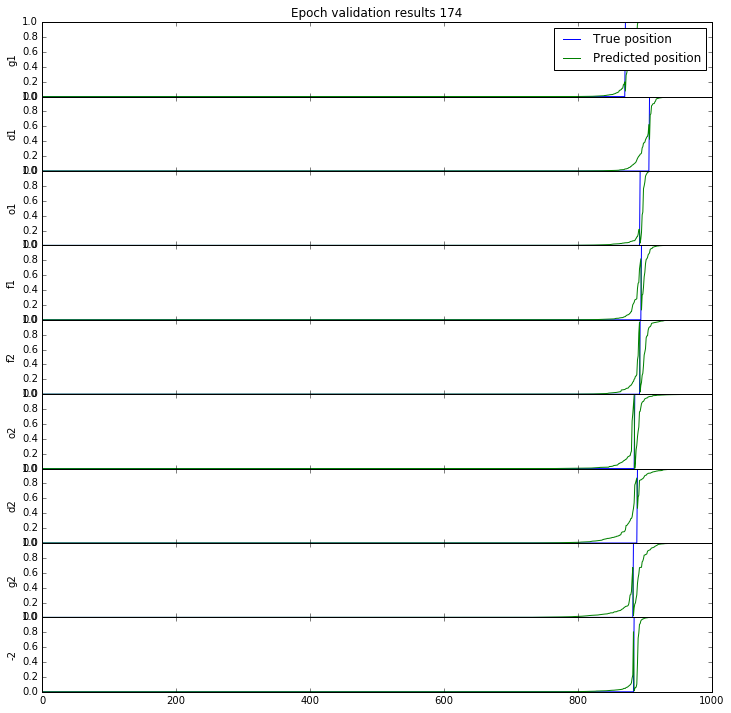

Wrote model to .\Models\weights_174.hdf
Epoch 175/175
1280/1279 [==============================] - 595s - loss: 0.5833 - categorical_accuracy: 0.8046 - val_loss: 0.1151 - val_categorical_accuracy: 0.9653
Wrote model to .\Models\weights_175.hdf
Epoch 176/176
1280/1279 [==============================] - 596s - loss: 0.5800 - categorical_accuracy: 0.8098 - val_loss: 0.1092 - val_categorical_accuracy: 0.9655
Wrote model to .\Models\weights_176.hdf
Epoch 177/177
1280/1279 [==============================] - 597s - loss: 0.5856 - categorical_accuracy: 0.8058 - val_loss: 0.1138 - val_categorical_accuracy: 0.9658
Wrote model to .\Models\weights_177.hdf
Epoch 178/178
1280/1279 [==============================] - 597s - loss: 0.5937 - categorical_accuracy: 0.8053 - val_loss: 0.1146 - val_categorical_accuracy: 0.9632
Wrote model to .\Models\weights_178.hdf
Epoch 179/179
1280/1279 [==============================] - 595s - loss: 0.5827 - categorical_accuracy: 0.8089 - val_loss: 0.1131 - val_categoric

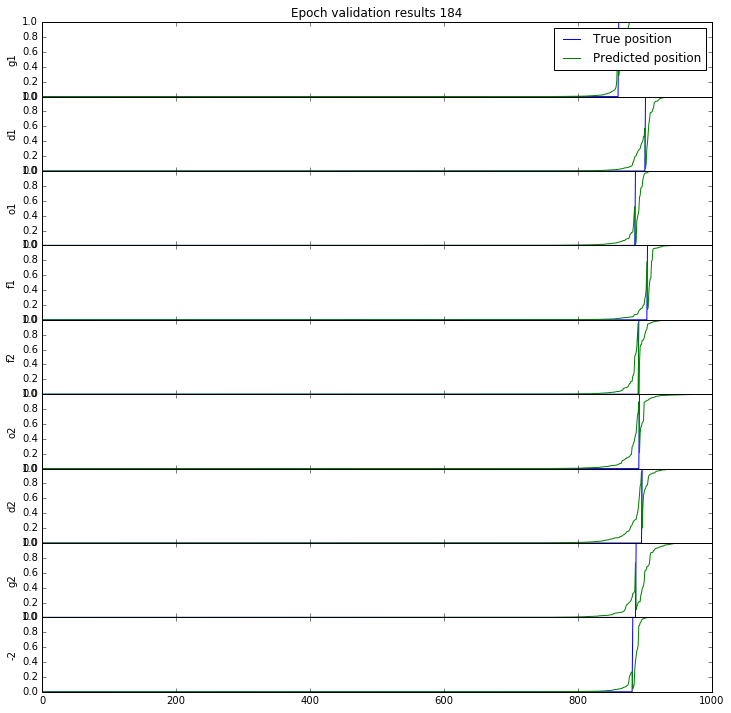

Wrote model to .\Models\weights_184.hdf
Epoch 185/185
1280/1279 [==============================] - 602s - loss: 0.5790 - categorical_accuracy: 0.8079 - val_loss: 0.1147 - val_categorical_accuracy: 0.9673
Wrote model to .\Models\weights_185.hdf
Epoch 186/186
1280/1279 [==============================] - 597s - loss: 0.5767 - categorical_accuracy: 0.8090 - val_loss: 0.1059 - val_categorical_accuracy: 0.9683
Wrote model to .\Models\weights_186.hdf
Epoch 187/187
1280/1279 [==============================] - 599s - loss: 0.5862 - categorical_accuracy: 0.8068 - val_loss: 0.1089 - val_categorical_accuracy: 0.9659
Wrote model to .\Models\weights_187.hdf
Epoch 188/188
1280/1279 [==============================] - 601s - loss: 0.5852 - categorical_accuracy: 0.8079 - val_loss: 0.1118 - val_categorical_accuracy: 0.9634
Wrote model to .\Models\weights_188.hdf
Epoch 189/189
1280/1279 [==============================] - 603s - loss: 0.5810 - categorical_accuracy: 0.8061 - val_loss: 0.1110 - val_categoric

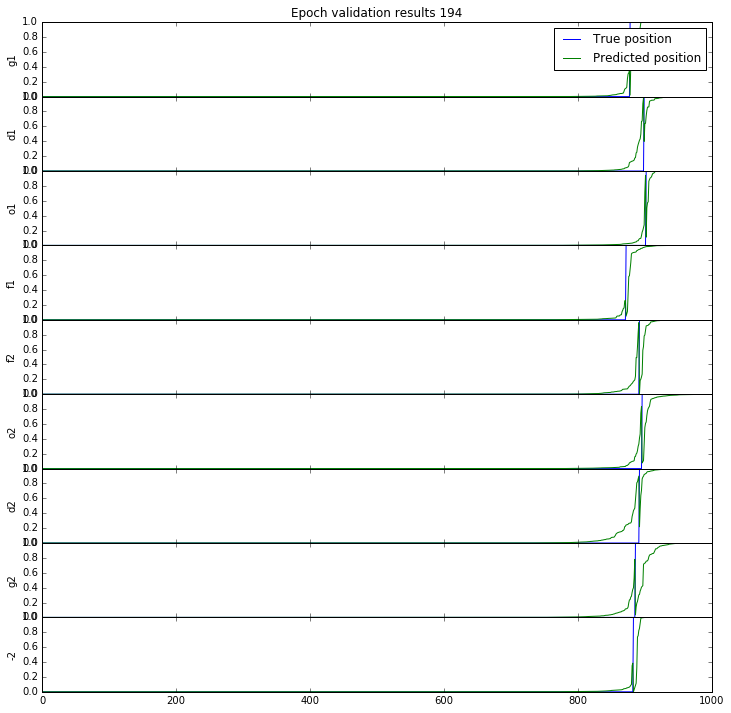

Wrote model to .\Models\weights_194.hdf
Epoch 195/195
1280/1279 [==============================] - 599s - loss: 0.5810 - categorical_accuracy: 0.8074 - val_loss: 0.1052 - val_categorical_accuracy: 0.9649
Wrote model to .\Models\weights_195.hdf
Epoch 196/196
1280/1279 [==============================] - 598s - loss: 0.5752 - categorical_accuracy: 0.8096 - val_loss: 0.1179 - val_categorical_accuracy: 0.9645
Wrote model to .\Models\weights_196.hdf
Epoch 197/197
1280/1279 [==============================] - 598s - loss: 0.5890 - categorical_accuracy: 0.8072 - val_loss: 0.1070 - val_categorical_accuracy: 0.9686
Wrote model to .\Models\weights_197.hdf
Epoch 198/198
1280/1279 [==============================] - 603s - loss: 0.5834 - categorical_accuracy: 0.8071 - val_loss: 0.1213 - val_categorical_accuracy: 0.9639
Wrote model to .\Models\weights_198.hdf
Epoch 199/199
1280/1279 [==============================] - 601s - loss: 0.5693 - categorical_accuracy: 0.8135 - val_loss: 0.1070 - val_categoric

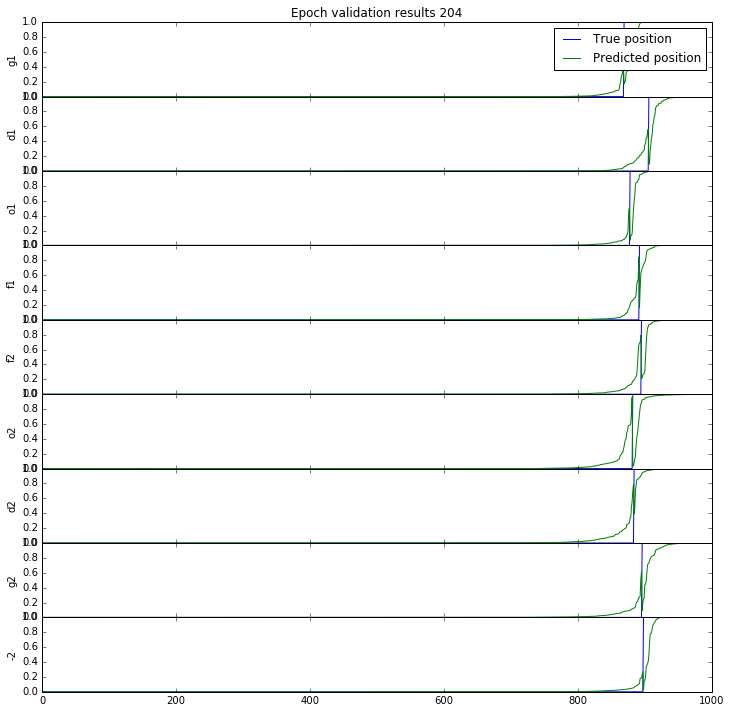

Wrote model to .\Models\weights_204.hdf
Epoch 205/205
1280/1279 [==============================] - 597s - loss: 0.5704 - categorical_accuracy: 0.8115 - val_loss: 0.1085 - val_categorical_accuracy: 0.9668
Wrote model to .\Models\weights_205.hdf
Epoch 206/206
1280/1279 [==============================] - 598s - loss: 0.5759 - categorical_accuracy: 0.8102 - val_loss: 0.1049 - val_categorical_accuracy: 0.9670
Wrote model to .\Models\weights_206.hdf
Epoch 207/207
1280/1279 [==============================] - 599s - loss: 0.5714 - categorical_accuracy: 0.8130 - val_loss: 0.1083 - val_categorical_accuracy: 0.9644
Wrote model to .\Models\weights_207.hdf
Epoch 208/208
 562/1279 [============>.................] - ETA: 312s - loss: 0.5738 - categorical_accuracy: 0.8079

KeyboardInterrupt: 

In [9]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.000005),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 143
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 30
batches_training_per_epoch = int(training.length / batch_size) / 5
batches_validation_per_epoch = int(validation.length / batch_size) / 5
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)

